In [1]:
import glob
import numpy as np
# hide numpy log warning
np.seterr(divide = 'ignore') 
import pandas as pd
import warnings
import seaborn as sns
import matplotlib.pyplot as plt

from biom import load_table
from tqdm.notebook import tqdm
from skbio.stats.distance import permanova
from scipy.spatial import distance
from scipy.linalg import khatri_rao
from skbio import DistanceMatrix
from gemelli.ctf import ctf
from gemelli.joint_ctf import joint_ctf
from gemelli.preprocessing import clr_transformation
# hide pandas Future/Deprecation Warning(s) for tutorial
warnings.filterwarnings("ignore", category=DeprecationWarning) 
warnings.simplefilter(action='ignore', category=FutureWarning)
# plotting
plt.style.use('ggplot')
sns.set_style('white')
%matplotlib inline

### functions

In [2]:
def plot_loadings(loadings, mf, 
                  mod_name, comp1, comp2, 
                  cat_of_interest, group_colors):
    
    t_load, s_load, f_load = loadings

    fig, axn = plt.subplots(1, 3, figsize=(18, 4), sharey=False)
    axn[0].plot(t_load[mod_name][['component_1', 
                                  'component_2', 
                                  'component_3']])
    axn[0].set_title('Temporal Loadings', fontsize=14)
    axn[0].legend(['PC1', 'PC2', 'PC3'])
    axn[1].scatter(s_load[mod_name][comp1],
                   s_load[mod_name][comp2],
                   #label=group_colors.keys(),
                   c=mf[cat_of_interest].map(group_colors))
    #axn[1].legend()
    axn[1].set_title('Individual Loadings', fontsize=14)
    axn[2].scatter(f_load[mod_name][comp1],
                   f_load[mod_name][comp2], c='black')
    axn[2].set_title('Feature Loadings', fontsize=14)
    plt.suptitle('Joint-CTF results ({})'.format(mod_name), 
                 fontsize=16, y=1.02)
    plt.setp(axn, xlabel=comp1.replace('_', ' '), 
                  ylabel=comp2.replace('_', ' '))
    plt.show()

def plot_feature_cov(tables, mod_cov, components,
                     sharey=True, axis_off=True):
    
    #get feature IDs for each modality
    feature_order = []
    for table in tables:
        feature_ids = table.ids(axis='observation').tolist()
        feature_order = feature_order + feature_ids

    n_comp = len(components)
    fig, axn = plt.subplots(1, n_comp, figsize=(5*n_comp, 4), 
                            sharey=sharey)

    for i, component in enumerate(components):
        cov_table = mod_cov[component]
        cov_table = cov_table.loc[feature_order, feature_order]
        #plot heatmap of feature covariance matrix
        sns.heatmap(cov_table, robust=True, cmap='vlag', 
                    center=0, ax=axn[i])
        axn[i].set_title('{}'.format(component))
    
    if axis_off:
        for ax in axn:
            ax.set_yticks([])
            ax.set_xticks([])

    plt.suptitle('Feature covariance', fontsize=16, y=1.02)
    plt.show()

def sub_feat_trajectory(table, feature_loadings, 
                        component, modality, zoom=True, 
                        quantile=0.95, pseudocount=0):
    # get the loadings
    floadings = feature_loadings[modality][component].copy()
    table_df = table.copy().to_dataframe()

    if zoom:
        #get top and bottom loading quantiles
        top_q = floadings.quantile(quantile)
        bottom_q = floadings.quantile(1-quantile)
        top_fts = floadings[floadings >= top_q].index
        bottom_fts = floadings[floadings <= bottom_q].index
        
        num = table_df.loc[top_fts].sum(axis=0)
        num += pseudocount
        denom = table_df.loc[bottom_fts].sum(axis=0)
        denom += pseudocount

        beta_l = np.log(num).values - np.log(denom).values
        beta_l = pd.DataFrame(beta_l, index=num.index, 
                              columns=[component])
    else:
        #calculate trajectories
        pass

    #drop any NaNs
    beta_l.dropna(inplace=True)

    return beta_l, top_fts, bottom_fts

def temporal_trajectory(individual_loadings, 
                        feature_loadings,
                        temporal_loadings, 
                        state_column, modality, 
                        component = 'component_1',
                        f_subset=True, quantile=0.95):
    #get loadings
    sloadings = individual_loadings[[component]].copy()
    floadings = feature_loadings[modality][[component]].copy()
    t_index = temporal_loadings[modality]['time_interval']
    tloadings = temporal_loadings[modality][[component]].copy()
    #add dummy column to all loadings
    sloadings['dummy'] = 1
    floadings['dummy'] = 1
    tloadings['dummy'] = 1

    #calculate the column-wise khatri-rao products
    #subject trajectory
    s_traj = khatri_rao(sloadings, tloadings)
    s_traj = pd.DataFrame(s_traj, columns=[component,'dummy'])
    #add subject IDs and resolution
    a_indexes_repeated = np.repeat(sloadings.index, tloadings.shape[0])
    c_indexes_tiled = np.tile(t_index, sloadings.shape[0])
    s_traj['subjectID'] = a_indexes_repeated
    s_traj[state_column] = c_indexes_tiled
    
    #feature trajectory
    if f_subset:
        #get top and bottom loading quantiles
        top_q = floadings[component].quantile(quantile)
        bottom_q = floadings[component].quantile(1-quantile)
        top_fts = floadings[floadings[component] >= top_q].index.tolist()
        bottom_fts = floadings[floadings[component] <= bottom_q].index.tolist()
        floadings = floadings.loc[top_fts+bottom_fts]
        f_traj = khatri_rao(floadings, tloadings)
    else:
        f_traj = khatri_rao(floadings, tloadings)
    
    f_traj = pd.DataFrame(f_traj, columns=[component,'dummy'])
    #add feature IDs and resolution
    b_indexes_repeated = np.repeat(floadings.index, tloadings.shape[0])
    c_indexes_tiled = np.tile(t_index, floadings.shape[0])
    f_traj['featureID'] = b_indexes_repeated
    f_traj[state_column] = c_indexes_tiled
    #if top/bottom features used, label them accordingly
    if f_subset:
        f_traj['quantile'] = ['top_q' if x in top_fts else 'bottom_q' for x in f_traj.featureID]

    #remove dummy columns
    s_traj.drop(columns=['dummy'], inplace=True)
    f_traj.drop(columns=['dummy'], inplace=True)
    return s_traj, f_traj

### load and preprocess data

In [3]:
# load filtered tables
body_site = 'Baby-Feces'
baby_gut_mf = pd.read_csv('../data/%s/metadata-filtered.tsv' % body_site, index_col=0)
baby_gut_table = load_table('../data/%s/table-filtered.biom' % body_site)

body_site = 'Baby-Forearm'
baby_skin_mf = pd.read_csv('../data/%s/metadata-filtered.tsv' % body_site, index_col=0)
baby_skin_table = load_table('../data/%s/table-filtered.biom' % body_site)

body_site = 'Baby-Mouth'
baby_mouth_mf = pd.read_csv('../data/%s/metadata-filtered.tsv' % body_site, index_col=0)
baby_mouth_table = load_table('../data/%s/table-filtered.biom' % body_site)

In [4]:
#calculate sequencing depth in each table
baby_gut_df = baby_gut_table.to_dataframe()
baby_skin_df = baby_skin_table.to_dataframe()

#calculate the average count for each sample
gut_depth = baby_gut_df.sum(axis=0).sum()/baby_gut_df.shape[1]
skin_depth = baby_skin_df.sum(axis=0).sum()/baby_skin_df.shape[1]
print('Avg count in gut samples: %.2f' % gut_depth)
print('Avg count in skin samples: %.2f' % skin_depth)

Avg count in gut samples: 57830.48
Avg count in skin samples: 38653.87


In [5]:
#calculate the average count for each feature
gut_depth = baby_gut_df.sum(axis=0).sum()/baby_gut_df.shape[0]
skin_depth = baby_skin_df.sum(axis=0).sum()/baby_skin_df.shape[0]
print('Avg count in gut features: %.2f' % gut_depth)
print('Avg count in skin features: %.2f' % skin_depth)

Avg count in gut features: 21414.99
Avg count in skin features: 2511.26


In [26]:
#count how many unique IDs are in each birth mode
subject_id_column = 'subjectid_unique'
print(baby_gut_mf.shape)
print(baby_gut_mf.subjectid_unique.nunique())
print(baby_gut_mf.date_sampling_category_days_continuous.nunique())
print(baby_gut_mf.groupby('birth_mode_ms')[subject_id_column].nunique())

(1107, 48)
133
18
birth_mode_ms
CS     40
Vag    93
Name: subjectid_unique, dtype: int64


In [27]:
#count how many unique IDs are in each birth mode
print(baby_skin_mf.shape)
print(baby_skin_mf.subjectid_unique.nunique())
print(baby_skin_mf.date_sampling_category_days_continuous.nunique())
print(baby_skin_mf.groupby('birth_mode_ms')[subject_id_column].nunique())

(612, 48)
74
18
birth_mode_ms
CS     17
Vag    57
Name: subjectid_unique, dtype: int64


In [28]:
#count how many unique IDs are in each birth mode
print(baby_mouth_mf.shape)
print(baby_mouth_mf.subjectid_unique.nunique())
print(baby_mouth_mf.date_sampling_category_days_continuous.nunique())
print(baby_mouth_mf.groupby('birth_mode_ms')[subject_id_column].nunique())

(603, 48)
71
18
birth_mode_ms
CS     16
Vag    55
Name: subjectid_unique, dtype: int64


In [30]:
vag_babies = baby_mouth_mf[baby_mouth_mf.birth_mode_ms == 'Vag']
cs_babies = baby_mouth_mf[baby_mouth_mf.birth_mode_ms == 'CS']
print("# samples")
print(vag_babies.shape)
print(cs_babies.shape)

print("Mean tps")
print(baby_mouth_mf[subject_id_column].value_counts().mean())
print(vag_babies[subject_id_column].value_counts().mean())
print(cs_babies[subject_id_column].value_counts().mean())
print("Max tps")
print(baby_mouth_mf[subject_id_column].value_counts().max())
print(vag_babies[subject_id_column].value_counts().max())
print(cs_babies[subject_id_column].value_counts().max())
print("Min tps")
print(baby_mouth_mf[subject_id_column].value_counts().min())
print(vag_babies[subject_id_column].value_counts().min())
print(cs_babies[subject_id_column].value_counts().min())

# samples
(428, 48)
(175, 48)
Mean tps
8.492957746478874
7.781818181818182
10.9375
Max tps
17
17
17
Min tps
2
2
5


### Joint-CTF with true data

In [10]:
# define temporary output directory
n_mods = 2
output_dir = '/Users/bec5786/Desktop/temp/beta_features/{}mod/'.format(n_mods)
csseed = False
tps = 'all'

if csseed:
    output_dir = '/Users/bec5786/Desktop/temp/beta_features/{}mod/CSseed_true/'.format(n_mods)
else:
    output_dir = '/Users/bec5786/Desktop/temp/beta_features/{}mod/CSseed_false/'.format(n_mods)

In [11]:
#(optional) subsetting
#define time splits
state_column = 'date_sampling_category_days_continuous'
splits_ = {'all':[0.0, 1.0, 2.0, 7.0, 14.0, 
                  21.0, 30.0, 60.0, 90.0, 120.0, 
                  150.0, 180.0, 210.0, 240.0, 
                  270.0, 300.0, 330.0, 360.0],
           '0-2':[0.0, 1.0, 2.0],
           '7-360':[7.0, 14.0, 30.0,
                    60, 120, 180, 360]}

if csseed == False:
    baby_gut_mf = baby_gut_mf[baby_gut_mf.birth_mode_ms != 'CSseed']
    baby_skin_mf = baby_skin_mf[baby_skin_mf.birth_mode_ms != 'CSseed']
    baby_mouth_mf = baby_mouth_mf[baby_mouth_mf.birth_mode_ms != 'CSseed']

# baby_gut_mf_120sub = baby_gut_mf[baby_gut_mf.date_sampling_category_days_continuous <= 120]
# baby_skin_mf_120sub = baby_skin_mf[baby_skin_mf.date_sampling_category_days_continuous <= 120]
# baby_mouth_mf_120sub = baby_mouth_mf[baby_mouth_mf.date_sampling_category_days_continuous <= 120]

baby_gut_mf_7_360 = baby_gut_mf[baby_gut_mf[state_column].isin(splits_['7-360'])]
baby_skin_mf_7_360 = baby_skin_mf[baby_skin_mf[state_column].isin(splits_['7-360'])]
baby_mouth_mf_7_360 = baby_mouth_mf[baby_mouth_mf[state_column].isin(splits_['7-360'])]

In [12]:
#pick the metadata to be used (original or subset)
if tps == 'all':
    mf1, mf2, mf3 = baby_gut_mf.copy(), baby_skin_mf.copy(), baby_mouth_mf.copy()
# elif tps == '120sub':
#     mf1, mf2, mf3 = baby_gut_mf_120sub.copy(), baby_skin_mf_120sub.copy(), baby_mouth_mf_120sub.copy()
elif tps == '7-360':
    mf1, mf2, mf3 = baby_gut_mf_7_360.copy(), baby_skin_mf_7_360.copy(), baby_mouth_mf_7_360.copy()

In [13]:
#make sure there are at least two time points per subject
subject_id_column = 'subjectid_unique'
ids_to_keep1 = mf1[subject_id_column].value_counts()[mf1[subject_id_column].value_counts() > 1].index
mf1 = mf1[mf1[subject_id_column].isin(ids_to_keep1)]

ids_to_keep2 = mf2[subject_id_column].value_counts()[mf2[subject_id_column].value_counts() > 1].index
mf2 = mf2[mf2[subject_id_column].isin(ids_to_keep2)]

ids_to_keep3 = mf3[subject_id_column].value_counts()[mf3[subject_id_column].value_counts() > 1].index
mf3 = mf3[mf3[subject_id_column].isin(ids_to_keep3)]

In [14]:
##2 modalities
#ensure subjects are shared across modalities
shared_subjects = [s_id for s_id in mf1.subjectid_unique.unique() if s_id in mf2.subjectid_unique.unique()]
print("# shared subjects: {}".format(len(shared_subjects)))
mf1 = mf1[mf1.subjectid_unique.isin(shared_subjects)]
mf2 = mf2[mf2.subjectid_unique.isin(shared_subjects)]
#sanity check
print(len(mf1.subjectid_unique.unique()))
print(len(mf2.subjectid_unique.unique()))

# shared subjects: 71
71
71


In [15]:
# ##3 modalities
# #ensure subjects are shared across modalities
# #ensure subjects are shared across modalities
# shared_subjects = [s_id for s_id in mf1.subjectid_unique.unique() if s_id in mf2.subjectid_unique.unique()]
# shared_subjects = [s_id for s_id in shared_subjects if s_id in mf3.subjectid_unique.unique()]
# print("# shared subjects: {}".format(len(shared_subjects)))
# mf1 = mf1[mf1.subjectid_unique.isin(shared_subjects)]
# mf2 = mf2[mf2.subjectid_unique.isin(shared_subjects)]
# mf3 = mf3[mf3.subjectid_unique.isin(shared_subjects)]
# #sanity check
# print(len(mf1.subjectid_unique.unique()))
# print(len(mf2.subjectid_unique.unique()))
# print(len(mf3.subjectid_unique.unique()))

# shared subjects: 67
67
67
67


In [16]:
#subset tables prior to transformation
table1 = baby_gut_table.copy().filter(mf1.index, axis='sample')
table2 = baby_skin_table.copy().filter(mf2.index, axis='sample')
table3 = baby_mouth_table.copy().filter(mf3.index, axis='sample')

table1 = clr_transformation(table1.copy(), pseudocount=0.5)
table2 = clr_transformation(table2.copy(), pseudocount=0.5)
table3 = clr_transformation(table3.copy(), pseudocount=0.5)

In [17]:
ctf_results = joint_ctf(tables=[table1, table2, table3],
                        sample_metadatas=[mf1, mf2],
                        modality_ids=['16S.1','16S.2'],
                        individual_id_column='subjectid_unique',
                        state_column='date_sampling_category_days_continuous')

(individual_loadings, feature_loadings, state_loadings, 
 eigenvalues, prop_explained, feature_covs) = ctf_results

Calculate components for component_1
Reached convergence in 15 iterations
Calculate components for component_2
Reached convergence in 10 iterations


Calculate components for component_3
Reached convergence in 16 iterations


In [18]:
comp1 = 'component_1'
comp2 = 'component_2'
cat_of_interest = 'birth_mode_ms'
state_column = 'date_sampling_category_days_continuous'
baby_combined_mf = pd.concat([mf1, mf2, mf3])
mf_all = baby_combined_mf.groupby('subjectid_unique').agg({cat_of_interest:'first'})

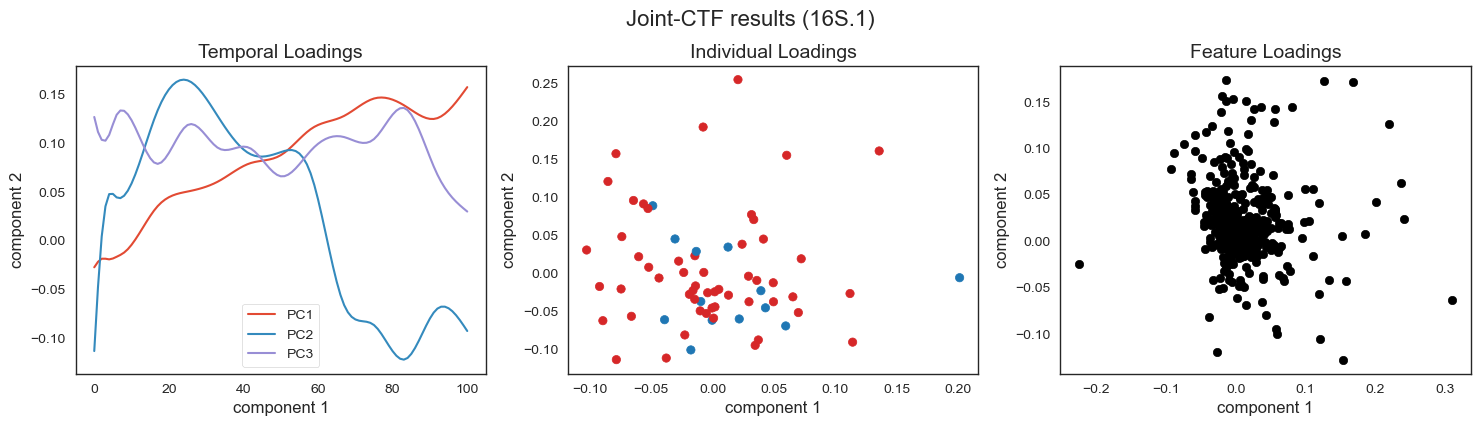

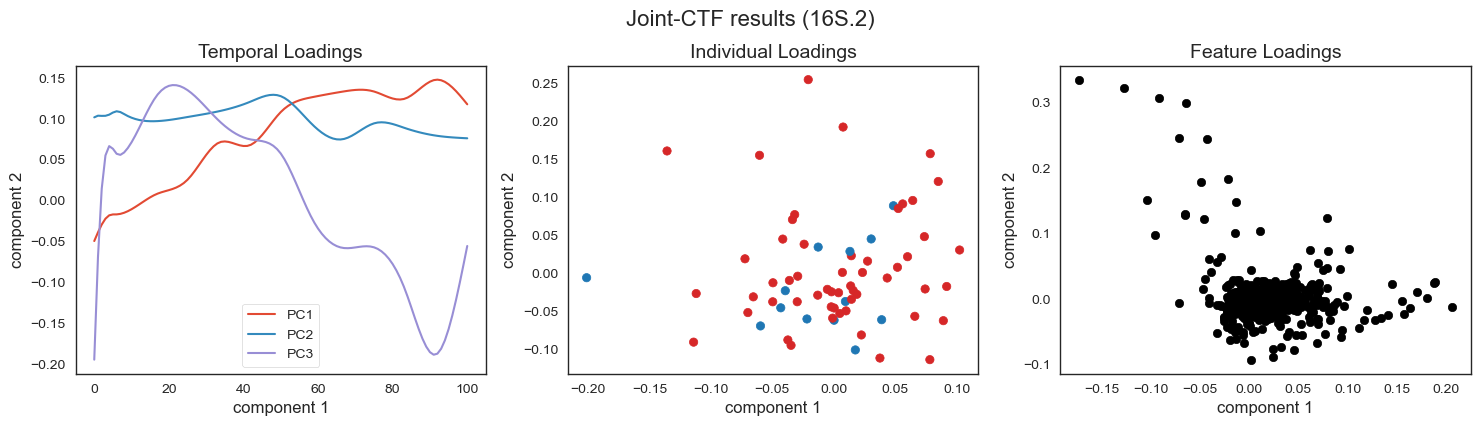

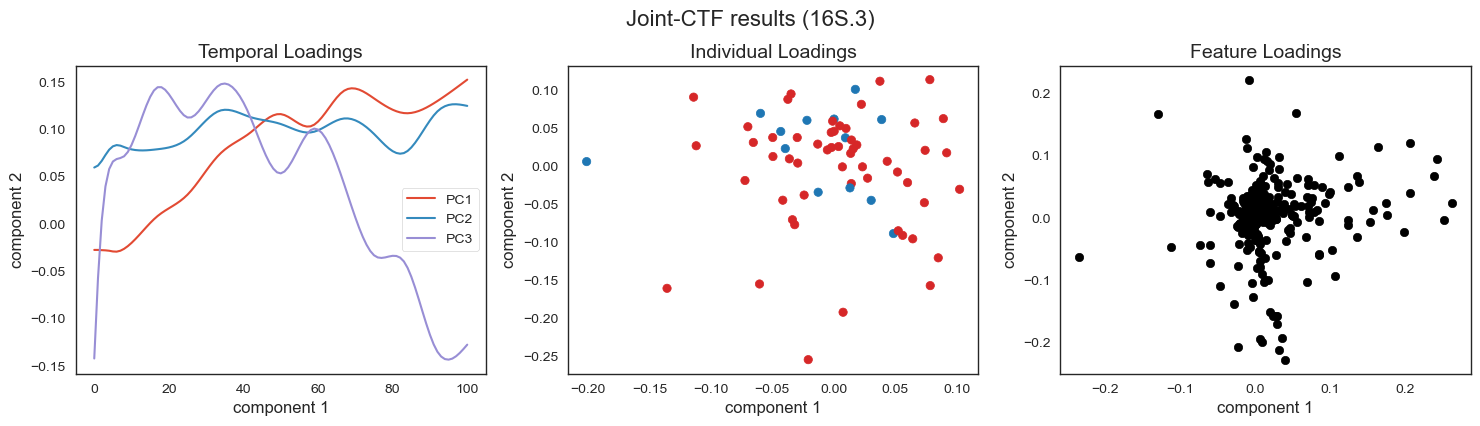

In [19]:
group_colors = {'CS': 'tab:blue', 'CSseed': 'tab:green', 'Vag': 'tab:red'}

plot_loadings(loadings=[state_loadings, individual_loadings, feature_loadings], 
              mf=mf_all, mod_name='16S.1', 
              comp1='component_1', comp2='component_2', 
              cat_of_interest='birth_mode_ms', group_colors=group_colors)

plot_loadings(loadings=[state_loadings, individual_loadings, feature_loadings], 
              mf=mf_all, mod_name='16S.2', 
              comp1='component_1', comp2='component_2', 
              cat_of_interest='birth_mode_ms', group_colors=group_colors)

plot_loadings(loadings=[state_loadings, individual_loadings, feature_loadings], 
              mf=mf_all, mod_name='16S.3', 
              comp1='component_1', comp2='component_2', 
              cat_of_interest='birth_mode_ms', group_colors=group_colors)

In [20]:
print(eigenvalues)
print(prop_explained.T)

       component_1  component_2  component_3
16S.1   794.141900   484.453701   305.008323
16S.2  1256.958110   495.675942   353.899859
16S.3  1037.603549   291.557538   259.439176
               component_1  component_2  component_3
var_explained     0.504644     0.262455     0.232901


/Users/bec5786/anaconda3/envs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/bec5786/anaconda3/envs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/bec5786/anaconda3/envs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


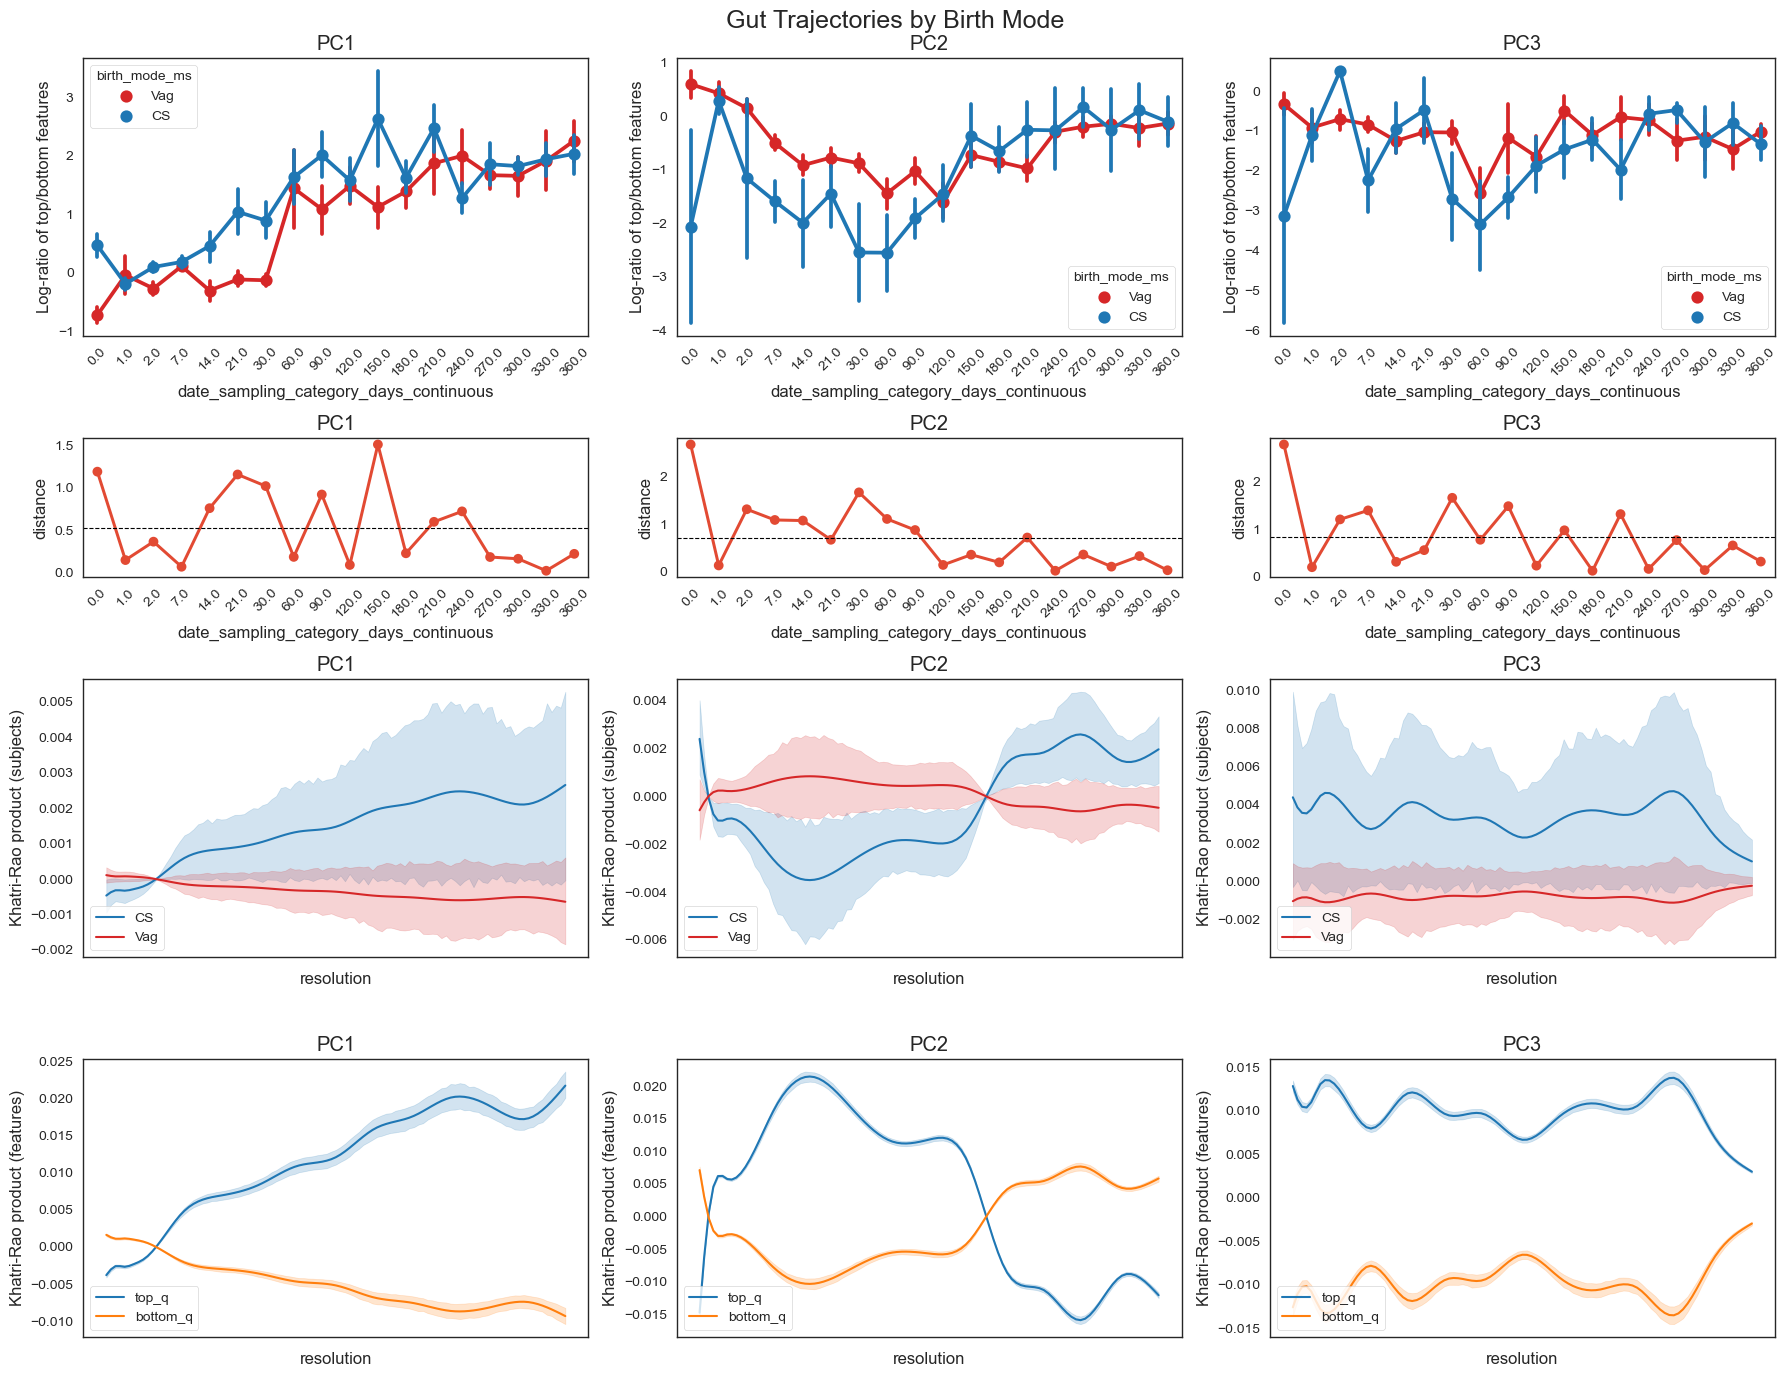

In [21]:
#calculate trajectories based on log-ratio abundance
components = ['component_1', 'component_2', 'component_3']
subject_id_column = 'subjectid_unique'
state_column =  'date_sampling_category_days_continuous'
cat_of_interest = 'birth_mode_ms'
quantile = 0.95
mod = '16S.1'
site = 'Gut'
table = table1

#individual_loadings, feature_loadings, state_loadings
fig, axn = plt.subplots(4, 3, figsize=(18, 14), gridspec_kw = {'height_ratios':[6,3,6,6]})
for i, component in enumerate(components):
    beta_l, top_fts, bottom_fts = sub_feat_trajectory(table, feature_loadings, component=component,
                                                      modality=mod, pseudocount=0.5, quantile=quantile)
    
    #save top and bottom features
    # q_text = int(100*(1 - quantile))
    # pd.DataFrame(top_fts, columns=['featureID']).to_csv('{}{}_top{}_features_PC{}_{}.txt'.format(output_dir, site, q_text, i+1, tps), 
    #                                                     sep='\t', index=False)
    # pd.DataFrame(bottom_fts, columns=['featureID']).to_csv('{}{}_bottom{}_features_PC{}_{}.txt'.format(output_dir, site, q_text, i+1, tps), 
    #                                                        sep='\t', index=False)

    #map columns of interest from mf
    beta_l[state_column] = beta_l.index.map(baby_combined_mf[state_column])
    beta_l['subjectID'] = beta_l.index.map(baby_combined_mf['subjectid_unique'])
    beta_l[cat_of_interest] = beta_l.index.map(baby_combined_mf[cat_of_interest])
    beta_l.dropna(inplace=True)

    #find timepoints at which trajectories seem to converge
    cat1, cat2 = beta_l[cat_of_interest].unique()[0:2]
    beta_l_dist = beta_l.groupby([state_column, 
                                    cat_of_interest]).mean()
    beta_l_dist = beta_l_dist.unstack()
    beta_l_dist.columns = beta_l_dist.columns.droplevel()
    beta_l_dist.reset_index(inplace=True)
    beta_l_dist['distance'] = np.sqrt(abs(beta_l_dist[cat1] - \
                                        beta_l_dist[cat2]) ** 2)

    #calculate trajectories based on khatri-rao product
    strajectory, ftrajectory = temporal_trajectory(individual_loadings['16S.1'], feature_loadings,
                                                    state_loadings, modality=mod,
                                                    state_column='resolution',
                                                    component=component,
                                                    f_subset=True, quantile=0.95)

    #map columns of interest from mf
    strajectory[cat_of_interest] = strajectory['subjectID'].map(mf_all[cat_of_interest])

    ##plotting
    #plot trajectory #1
    sns.pointplot(x=state_column, y=component, hue=cat_of_interest, 
                  data=beta_l, ax=axn[0,i], ci=68, palette=group_colors)
    axn[0,i].set_title('PC{}'.format(i+1))
    xlabels = axn[0,i].get_xticklabels()
    axn[0,i].set_xticklabels(xlabels, rotation=45)
    axn[0,i].set_ylabel('Log-ratio of top/bottom features')
    #plot distance between points in trajectory #1
    sns.pointplot(x=state_column, y='distance', data=beta_l_dist, 
                  ax=axn[1,i], errorbar=None, scale=0.8)
    axn[1,i].set_title('PC{}'.format(i+1))
    axn[1,i].axhline(y=beta_l_dist.distance.mean(), color='k', ls='--', lw=0.8)
    axn[1,i].set_xticklabels(xlabels, rotation=45)
    #plot trajectory #2
    sns.lineplot(x='resolution', y=component, hue=cat_of_interest, 
                 data=strajectory, ax=axn[2,i], ci=68, palette=group_colors)
    axn[2,i].set_title('PC{}'.format(i+1))
    axn[2,i].legend(loc='lower left')
    axn[2,i].set_xticklabels([], rotation=45)
    axn[2,i].set_ylabel('Khatri-Rao product (subjects)')
    #plot trajectory #3
    sns.lineplot(x='resolution', y=component, hue='quantile', 
                 data=ftrajectory, ax=axn[3,i], ci=68, palette='tab10')
    axn[3,i].set_title('PC{}'.format(i+1))
    axn[3,i].legend(loc='lower left')
    axn[3,i].set_xticklabels([], rotation=45)
    axn[3,i].set_ylabel('Khatri-Rao product (features)')

plt.suptitle('{} Trajectories by Birth Mode'.format(site), fontsize=18)
plt.tight_layout()
plt.show()

/Users/bec5786/anaconda3/envs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/bec5786/anaconda3/envs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


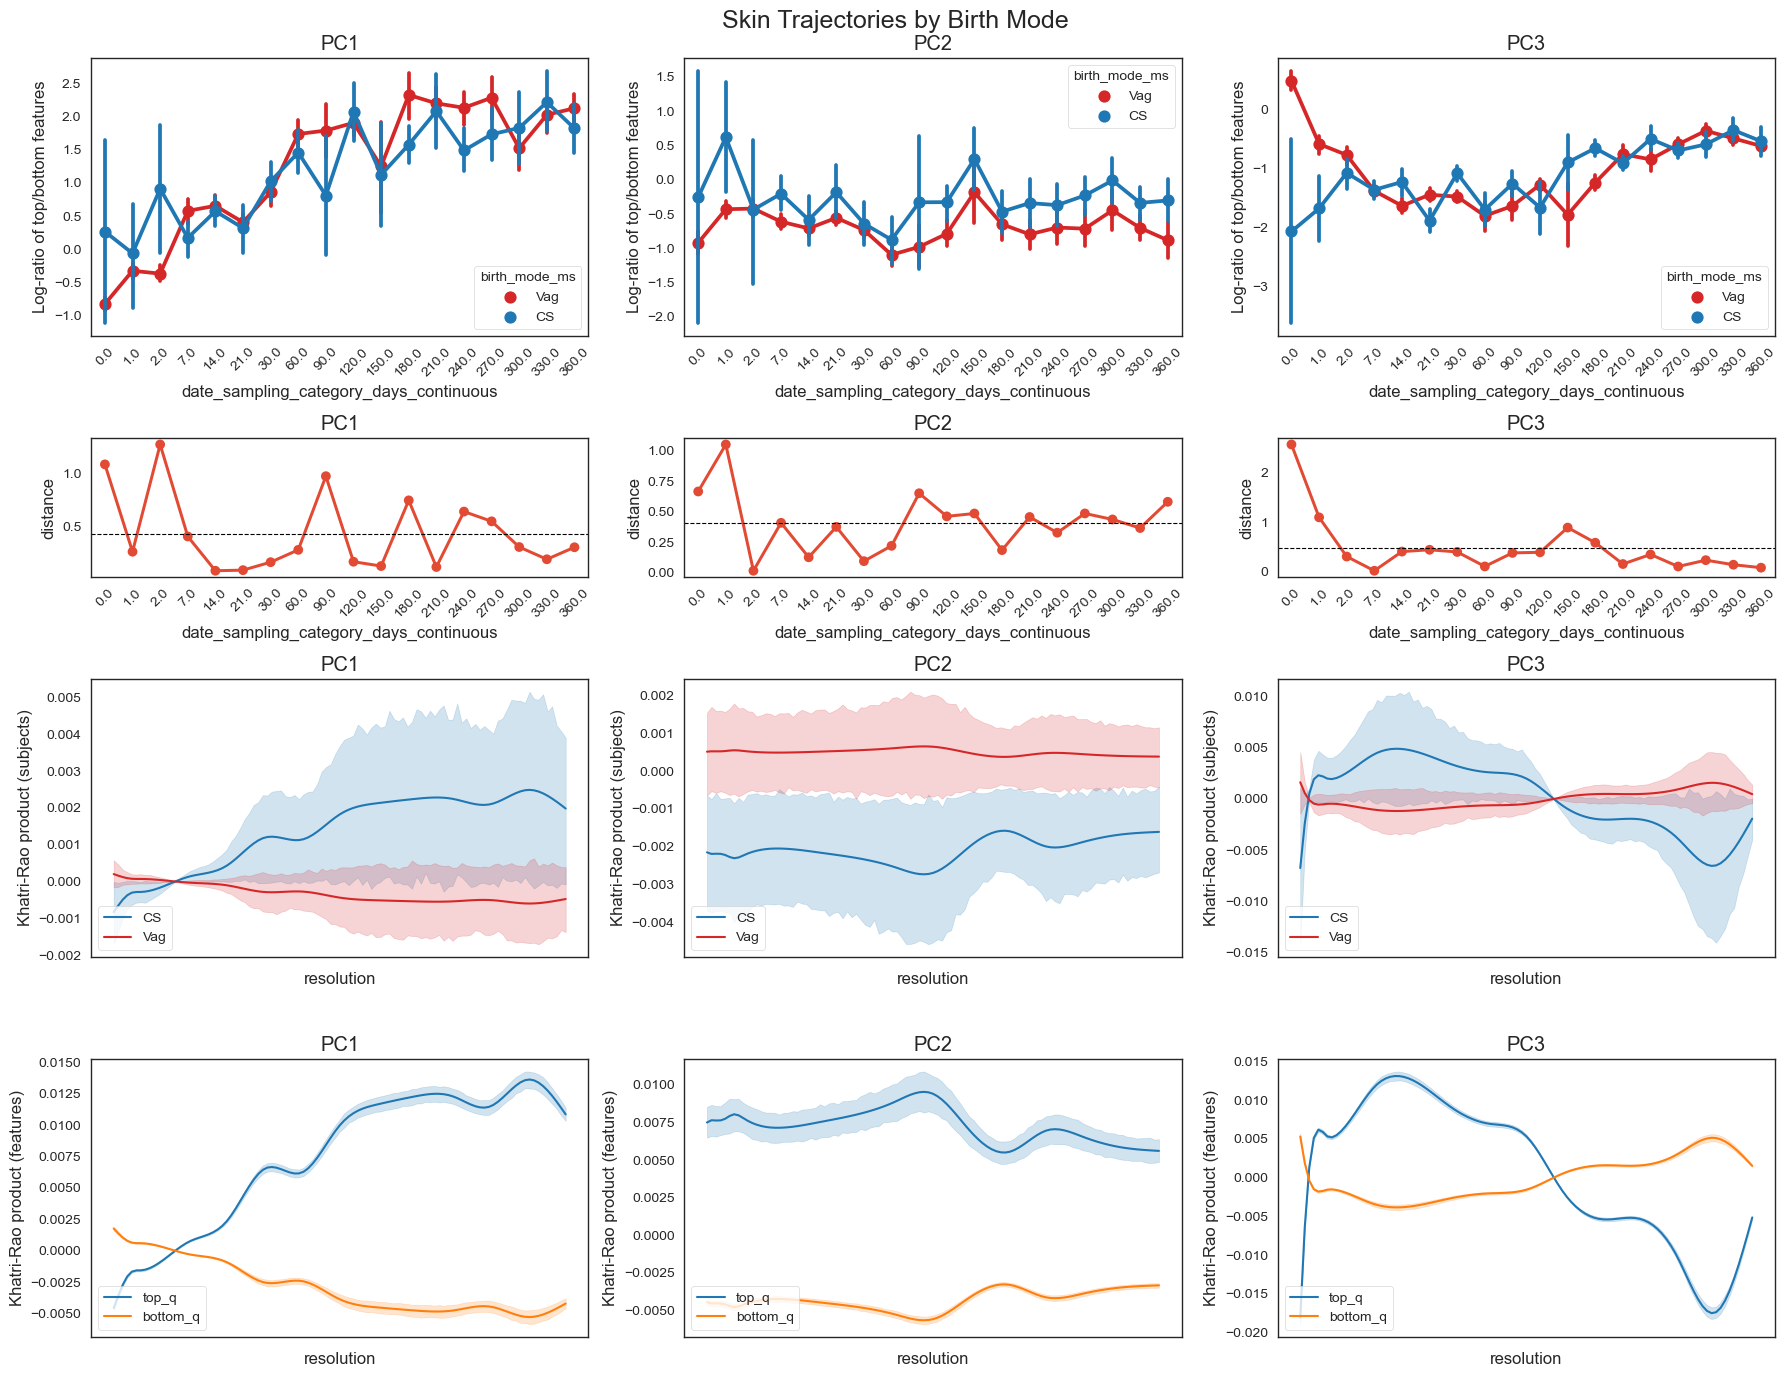

In [22]:
#calculate trajectories based on log-ratio abundance
components = ['component_1', 'component_2', 'component_3']
subject_id_column = 'subjectid_unique'
state_column =  'date_sampling_category_days_continuous'
cat_of_interest = 'birth_mode_ms'
quantile = 0.95
mod = '16S.2'
site = 'Skin'
table = table2

#individual_loadings, feature_loadings, state_loadings
fig, axn = plt.subplots(4, 3, figsize=(18, 14), gridspec_kw = {'height_ratios':[6,3,6,6]})
for i, component in enumerate(components):
    beta_l, top_fts, bottom_fts = sub_feat_trajectory(table, feature_loadings, component=component,
                                                      modality=mod, pseudocount=0.5, quantile=quantile)
    
    #save top and bottom features
    # q_text = int(100*(1 - quantile))
    # pd.DataFrame(top_fts, columns=['featureID']).to_csv('{}{}_top{}_features_PC{}_{}.txt'.format(output_dir, site, q_text, i+1, tps), 
    #                                                     sep='\t', index=False)
    # pd.DataFrame(bottom_fts, columns=['featureID']).to_csv('{}{}_bottom{}_features_PC{}_{}.txt'.format(output_dir, site, q_text, i+1, tps), 
    #                                                        sep='\t', index=False)

    #map columns of interest from mf
    beta_l[state_column] = beta_l.index.map(baby_combined_mf[state_column])
    beta_l['subjectID'] = beta_l.index.map(baby_combined_mf['subjectid_unique'])
    beta_l[cat_of_interest] = beta_l.index.map(baby_combined_mf[cat_of_interest])
    beta_l.dropna(inplace=True)

    #find timepoints at which trajectories seem to converge
    cat1, cat2 = beta_l[cat_of_interest].unique()[0:2]
    beta_l_dist = beta_l.groupby([state_column, 
                                    cat_of_interest]).mean()
    beta_l_dist = beta_l_dist.unstack()
    beta_l_dist.columns = beta_l_dist.columns.droplevel()
    beta_l_dist.reset_index(inplace=True)
    beta_l_dist['distance'] = np.sqrt(abs(beta_l_dist[cat1] - \
                                        beta_l_dist[cat2]) ** 2)

    #calculate trajectories based on khatri-rao product
    strajectory, ftrajectory = temporal_trajectory(individual_loadings['16S.1'], feature_loadings,
                                                    state_loadings, modality=mod,
                                                    state_column='resolution',
                                                    component=component,
                                                    f_subset=True, quantile=0.95)

    #map columns of interest from mf
    strajectory[cat_of_interest] = strajectory['subjectID'].map(mf_all[cat_of_interest])

    ##plotting
    #plot trajectory #1
    sns.pointplot(x=state_column, y=component, hue=cat_of_interest, 
                  data=beta_l, ax=axn[0,i], ci=68, palette=group_colors)
    axn[0,i].set_title('PC{}'.format(i+1))
    xlabels = axn[0,i].get_xticklabels()
    axn[0,i].set_xticklabels(xlabels, rotation=45)
    axn[0,i].set_ylabel('Log-ratio of top/bottom features')
    #plot distance between points in trajectory #1
    sns.pointplot(x=state_column, y='distance', data=beta_l_dist, 
                  ax=axn[1,i], errorbar=None, scale=0.8)
    axn[1,i].set_title('PC{}'.format(i+1))
    axn[1,i].axhline(y=beta_l_dist.distance.mean(), color='k', ls='--', lw=0.8)
    axn[1,i].set_xticklabels(xlabels, rotation=45)
    #plot trajectory #2
    sns.lineplot(x='resolution', y=component, hue=cat_of_interest, 
                 data=strajectory, ax=axn[2,i], ci=68, palette=group_colors)
    axn[2,i].set_title('PC{}'.format(i+1))
    axn[2,i].legend(loc='lower left')
    axn[2,i].set_xticklabels([], rotation=45)
    axn[2,i].set_ylabel('Khatri-Rao product (subjects)')
    #plot trajectory #3
    sns.lineplot(x='resolution', y=component, hue='quantile', 
                 data=ftrajectory, ax=axn[3,i], ci=68, palette='tab10')
    axn[3,i].set_title('PC{}'.format(i+1))
    axn[3,i].legend(loc='lower left')
    axn[3,i].set_xticklabels([], rotation=45)
    axn[3,i].set_ylabel('Khatri-Rao product (features)')

plt.suptitle('{} Trajectories by Birth Mode'.format(site), fontsize=18)
plt.tight_layout()
plt.show()

/Users/bec5786/anaconda3/envs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/bec5786/anaconda3/envs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/bec5786/anaconda3/envs/qiime2-amplicon-2024.2/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


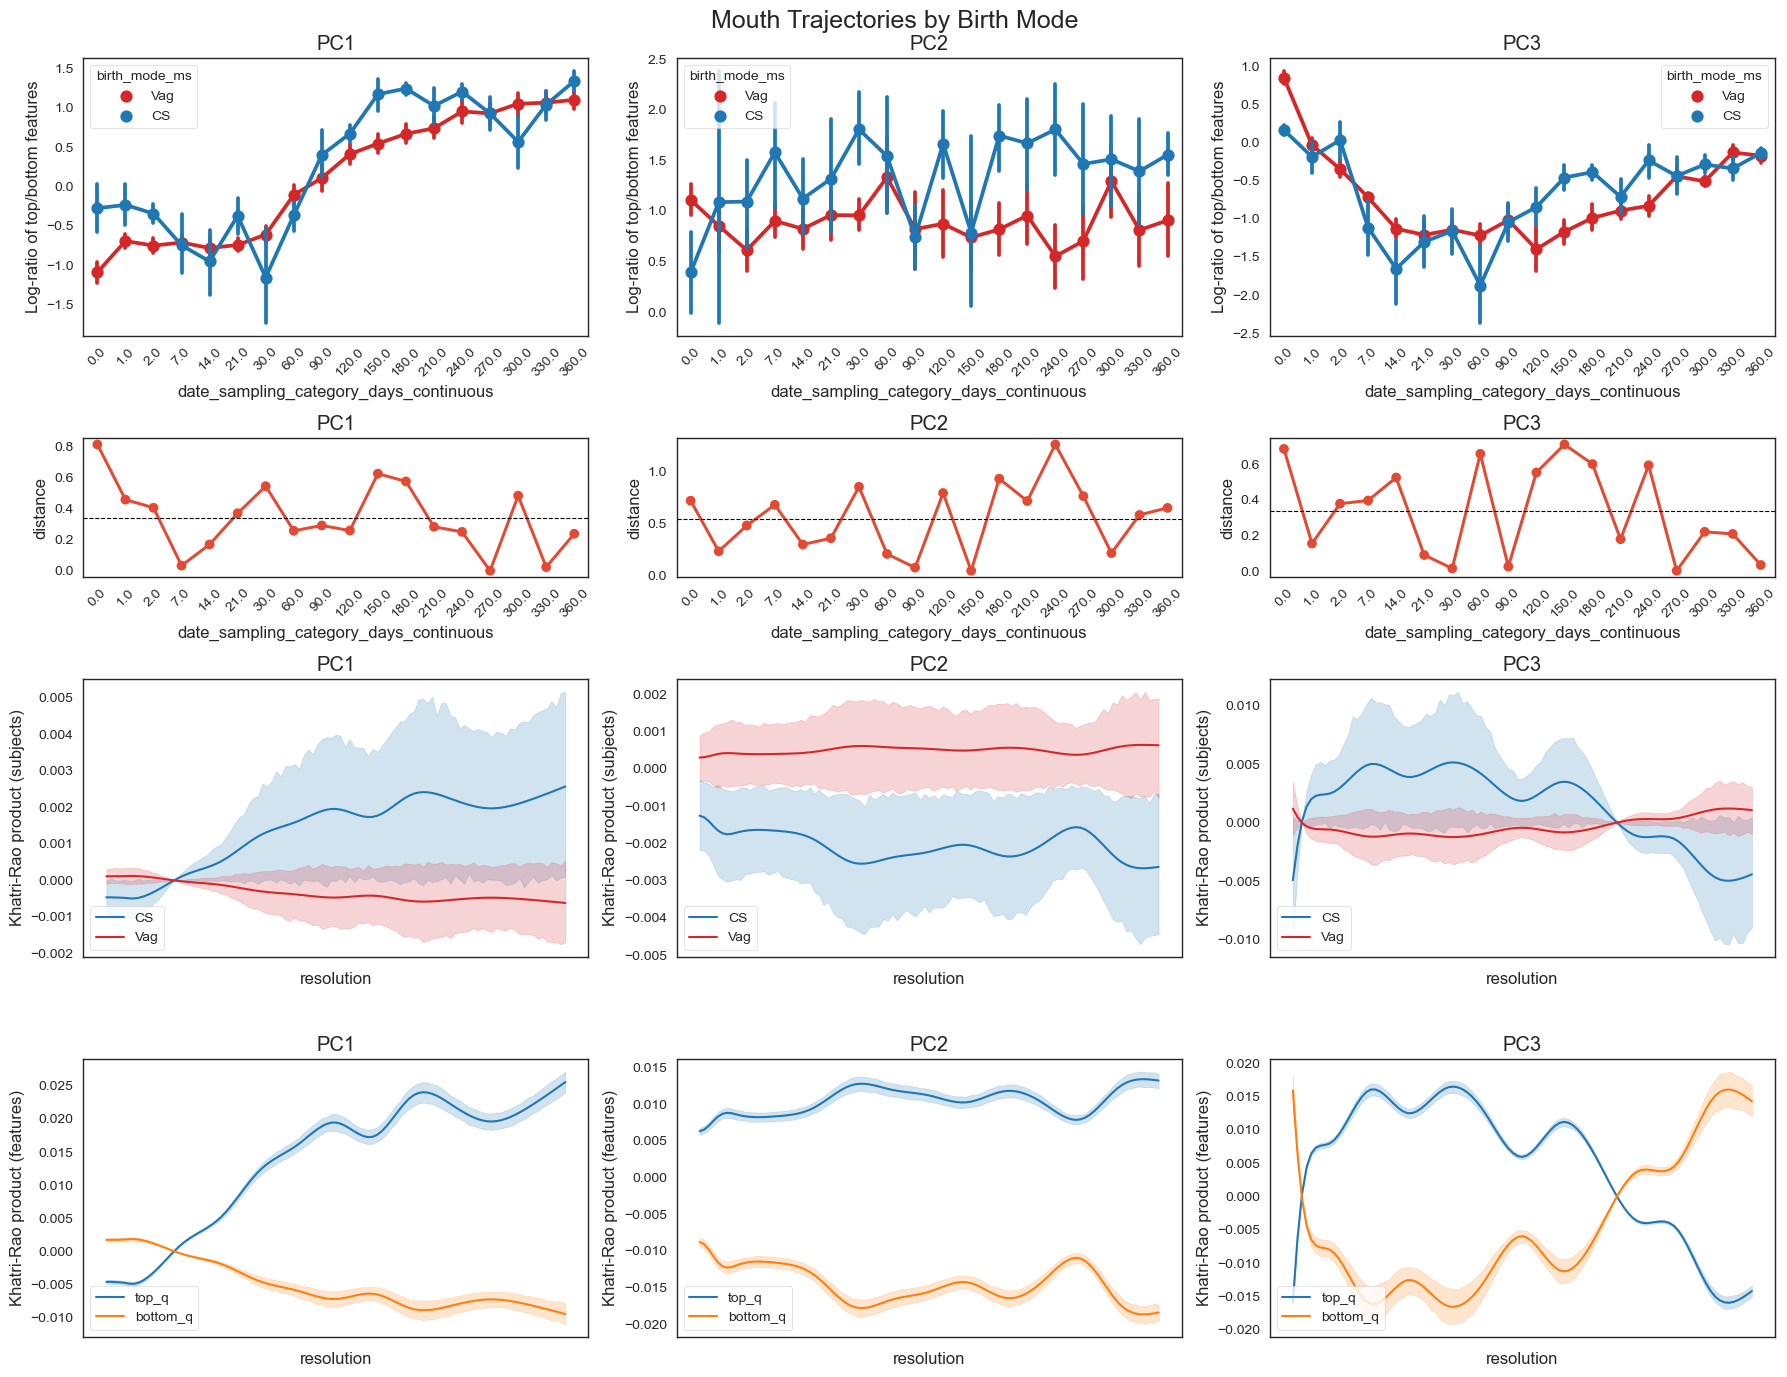

In [23]:
#calculate trajectories based on log-ratio abundance
components = ['component_1', 'component_2', 'component_3']
subject_id_column = 'subjectid_unique'
state_column =  'date_sampling_category_days_continuous'
cat_of_interest = 'birth_mode_ms'
quantile = 0.95
mod = '16S.3'
site = 'Mouth'
table = table3

#individual_loadings, feature_loadings, state_loadings
fig, axn = plt.subplots(4, 3, figsize=(18, 14), gridspec_kw = {'height_ratios':[6,3,6,6]})
for i, component in enumerate(components):
    beta_l, top_fts, bottom_fts = sub_feat_trajectory(table, feature_loadings, component=component,
                                                      modality=mod, pseudocount=0.5, quantile=quantile)
    
    #save top and bottom features
    # q_text = int(100*(1 - quantile))
    # pd.DataFrame(top_fts, columns=['featureID']).to_csv('{}{}_top{}_features_PC{}_{}.txt'.format(output_dir, site, q_text, i+1, tps), 
    #                                                     sep='\t', index=False)
    # pd.DataFrame(bottom_fts, columns=['featureID']).to_csv('{}{}_bottom{}_features_PC{}_{}.txt'.format(output_dir, site, q_text, i+1, tps), 
    #                                                        sep='\t', index=False)

    #map columns of interest from mf
    beta_l[state_column] = beta_l.index.map(baby_combined_mf[state_column])
    beta_l['subjectID'] = beta_l.index.map(baby_combined_mf['subjectid_unique'])
    beta_l[cat_of_interest] = beta_l.index.map(baby_combined_mf[cat_of_interest])
    beta_l.dropna(inplace=True)

    #find timepoints at which trajectories seem to converge
    cat1, cat2 = beta_l[cat_of_interest].unique()[0:2]
    beta_l_dist = beta_l.groupby([state_column, 
                                    cat_of_interest]).mean()
    beta_l_dist = beta_l_dist.unstack()
    beta_l_dist.columns = beta_l_dist.columns.droplevel()
    beta_l_dist.reset_index(inplace=True)
    beta_l_dist['distance'] = np.sqrt(abs(beta_l_dist[cat1] - \
                                        beta_l_dist[cat2]) ** 2)

    #calculate trajectories based on khatri-rao product
    strajectory, ftrajectory = temporal_trajectory(individual_loadings['16S.1'], feature_loadings,
                                                    state_loadings, modality=mod,
                                                    state_column='resolution',
                                                    component=component,
                                                    f_subset=True, quantile=0.95)

    #map columns of interest from mf
    strajectory[cat_of_interest] = strajectory['subjectID'].map(mf_all[cat_of_interest])

    ##plotting
    #plot trajectory #1
    sns.pointplot(x=state_column, y=component, hue=cat_of_interest, 
                  data=beta_l, ax=axn[0,i], ci=68, palette=group_colors)
    axn[0,i].set_title('PC{}'.format(i+1))
    xlabels = axn[0,i].get_xticklabels()
    axn[0,i].set_xticklabels(xlabels, rotation=45)
    axn[0,i].set_ylabel('Log-ratio of top/bottom features')
    #plot distance between points in trajectory #1
    sns.pointplot(x=state_column, y='distance', data=beta_l_dist, 
                  ax=axn[1,i], errorbar=None, scale=0.8)
    axn[1,i].set_title('PC{}'.format(i+1))
    axn[1,i].axhline(y=beta_l_dist.distance.mean(), color='k', ls='--', lw=0.8)
    axn[1,i].set_xticklabels(xlabels, rotation=45)
    #plot trajectory #2
    sns.lineplot(x='resolution', y=component, hue=cat_of_interest, 
                 data=strajectory, ax=axn[2,i], ci=68, palette=group_colors)
    axn[2,i].set_title('PC{}'.format(i+1))
    axn[2,i].legend(loc='lower left')
    axn[2,i].set_xticklabels([], rotation=45)
    axn[2,i].set_ylabel('Khatri-Rao product (subjects)')
    #plot trajectory #3
    sns.lineplot(x='resolution', y=component, hue='quantile', 
                 data=ftrajectory, ax=axn[3,i], ci=68, palette='tab10')
    axn[3,i].set_title('PC{}'.format(i+1))
    axn[3,i].legend(loc='lower left')
    axn[3,i].set_xticklabels([], rotation=45)
    axn[3,i].set_ylabel('Khatri-Rao product (features)')

plt.suptitle('{} Trajectories by Birth Mode'.format(site), fontsize=18)
plt.tight_layout()
plt.show()

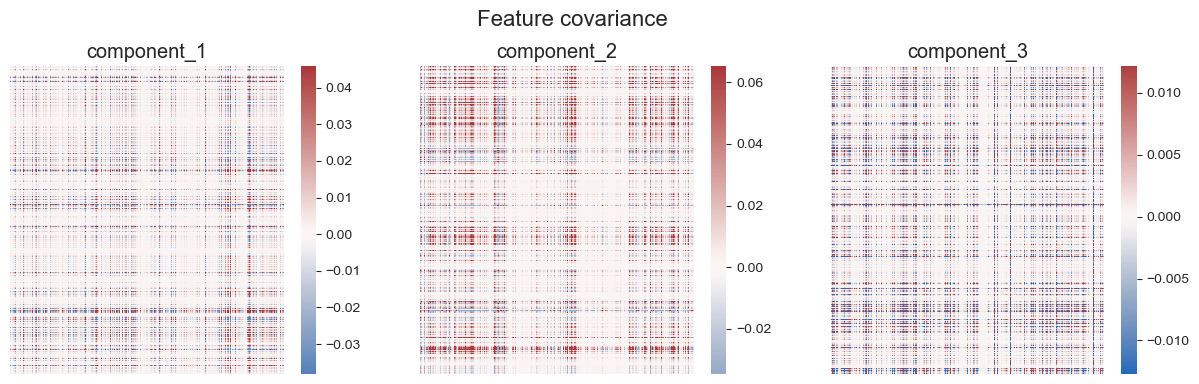

In [24]:
#plot covariance of a subset of features
plot_feature_cov(tables=[table1, table2, table3], mod_cov=feature_covs, 
                 components=['component_1', 'component_2', 'component_3'])

In [25]:
stop

NameError: name 'stop' is not defined

In [ ]:
##compare top features in one-mod vs two-mod decomposition
#load one-mod decomposition
top5_gut_individual_pc1 = pd.read_csv('/Users/bec5786/Desktop/temp/beta_features/1mod/CSseed_false/Gut_top5_features_PC1_all.txt', sep='\t')
print('top5_gut_individual:', top5_gut_individual_pc1.shape)
top5_skin_individual_pc1 = pd.read_csv('/Users/bec5786/Desktop/temp/beta_features/1mod/CSseed_false/Skin_top5_features_PC1_all.txt', sep='\t')
print('top5_skin_individual:', top5_skin_individual_pc1.shape)
#load two-mod decomposition
top5_gut_joint_pc1 = pd.read_csv('/Users/bec5786/Desktop/temp/beta_features/2mod/CSseed_false/Gut_top5_features_PC1_all.txt', sep='\t')
print('top5_gut_joint:', top5_gut_joint_pc1.shape)
top5_skin_joint_pc1 = pd.read_csv('/Users/bec5786/Desktop/temp/beta_features/2mod/CSseed_false/Skin_top5_features_PC1_all.txt', sep='\t')
print('top5_skin_joint:', top5_skin_joint_pc1.shape)

top5_gut_individual: (27, 1)
top5_skin_individual: (64, 1)
top5_gut_joint: (27, 1)
top5_skin_joint: (64, 1)


In [ ]:
#repeat for bottom 5% features
#load one-mod decomposition
bottom5_gut_individual_pc1 = pd.read_csv('/Users/bec5786/Desktop/temp/beta_features/1mod/CSseed_false/Gut_bottom5_features_PC1_all.txt', sep='\t')
print('bottom5_gut_individual:', bottom5_gut_individual_pc1.shape)
bottom5_skin_individual_pc1 = pd.read_csv('/Users/bec5786/Desktop/temp/beta_features/1mod/CSseed_false/Skin_bottom5_features_PC1_all.txt', sep='\t')
print('bottom5_skin_individual:', bottom5_skin_individual_pc1.shape)
#load two-mod decomposition
bottom5_gut_joint_pc1 = pd.read_csv('/Users/bec5786/Desktop/temp/beta_features/2mod/CSseed_false/Gut_bottom5_features_PC1_all.txt', sep='\t')
print('bottom5_gut_joint:', bottom5_gut_joint_pc1.shape)
bottom5_skin_joint_pc1 = pd.read_csv('/Users/bec5786/Desktop/temp/beta_features/2mod/CSseed_false/Skin_bottom5_features_PC1_all.txt', sep='\t')
print('bottom5_skin_joint:', bottom5_skin_joint_pc1.shape)

bottom5_gut_individual: (27, 1)
bottom5_skin_individual: (64, 1)
bottom5_gut_joint: (27, 1)
bottom5_skin_joint: (64, 1)


In [ ]:
#calculate intersection of top features
print("Top 5% features:")
gut_shared = set(top5_gut_individual_pc1.featureID).intersection(top5_gut_joint_pc1.featureID)
skin_shared = set(top5_skin_individual_pc1.featureID).intersection(top5_skin_joint_pc1.featureID)
print("# shared gut features: {}".format(len(gut_shared)))
print("# shared skin features: {}".format(len(skin_shared)))

print("Bottom 5% features:")
gut_shared = set(bottom5_gut_individual_pc1.featureID).intersection(bottom5_gut_joint_pc1.featureID)
skin_shared = set(bottom5_skin_individual_pc1.featureID).intersection(bottom5_skin_joint_pc1.featureID)
print("# shared gut features: {}".format(len(gut_shared)))
print("# shared skin features: {}".format(len(skin_shared)))

Top 5% features:
# shared gut features: 0
# shared skin features: 63
Bottom 5% features:
# shared gut features: 0
# shared skin features: 61


In [ ]:
gut_shared = set(top5_gut_individual_pc1.featureID).intersection(bottom5_gut_joint_pc1.featureID)
skin_shared = set(top5_skin_individual_pc1.featureID).intersection(bottom5_skin_joint_pc1.featureID)
print("# shared gut features: {}".format(len(gut_shared)))
print("# shared skin features: {}".format(len(skin_shared)))

# shared gut features: 13
# shared skin features: 0


In [ ]:
##compare top features in one-mod vs two-mod decomposition
#load one-mod decomposition
top5_gut_individual_pc2 = pd.read_csv('/Users/bec5786/Desktop/temp/beta_features/1mod/CSseed_false/Gut_top5_features_PC2_all.txt', sep='\t')
print('top5_gut_individual:', top5_gut_individual_pc2.shape)
top5_skin_individual_pc2 = pd.read_csv('/Users/bec5786/Desktop/temp/beta_features/1mod/CSseed_false/Skin_top5_features_PC2_all.txt', sep='\t')
print('top5_skin_individual:', top5_skin_individual_pc2.shape)
#load two-mod decomposition
top5_gut_joint_pc2 = pd.read_csv('/Users/bec5786/Desktop/temp/beta_features/2mod/CSseed_false/Gut_top5_features_PC2_all.txt', sep='\t')
print('top5_gut_joint:', top5_gut_joint_pc2.shape)
top5_skin_joint_pc2 = pd.read_csv('/Users/bec5786/Desktop/temp/beta_features/2mod/CSseed_false/Skin_top5_features_PC2_all.txt', sep='\t')
print('top5_skin_joint:', top5_skin_joint_pc2.shape)

top5_gut_individual: (27, 1)
top5_skin_individual: (64, 1)
top5_gut_joint: (27, 1)
top5_skin_joint: (64, 1)


In [ ]:
print(len(set(top5_skin_individual_pc1.featureID).intersection(top5_skin_individual_pc2.featureID)))
print(len(set(top5_gut_individual_pc1.featureID).intersection(top5_gut_individual_pc2.featureID)))

16
7


In [ ]:
print(len(set(top5_gut_individual_pc1.featureID).intersection(top5_gut_joint_pc2.featureID)))
print(len(set(top5_gut_individual_pc2.featureID).intersection(top5_gut_joint_pc1.featureID)))

11
5


In [ ]:
#calculate intersection of top features
gut_shared_pc2 = set(top5_gut_individual_pc2.featureID).intersection(top5_gut_joint_pc2.featureID)
skin_shared_pc2 = set(top5_skin_individual_pc2.featureID).intersection(top5_skin_joint_pc2.featureID)
print("# shared gut features: {}".format(len(gut_shared)))
print("# shared skin features: {}".format(len(skin_shared)))

# shared gut features: 0
# shared skin features: 63
